In [6]:
!pip install pydmd


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from pydmd import EDMD
import os
import sys
from sklearn.preprocessing import StandardScaler
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
from utils.compute_rsme import compute_rmse_over_time
from systems.lotka_volterra import simulate as simulate_lv
from systems.lorenz import simulate as simulate_lorenz

In [8]:
def load_single_trajectory(npz_path, trajectory_index=0):
    data = np.load(npz_path, allow_pickle=True)["trajectories"]
    traj_dict = data[trajectory_index]
    traj = traj_dict["traj"]
    z0 = traj_dict["z0"]
    t = traj_dict["t"]
    return traj, t, z0

def sample_arrows_by_distance(traj, min_dist):
    arrow_indices = [0]
    last = traj[0]
    for i in range(1, len(traj)):
        dist = np.linalg.norm(traj[i] - last)
        if dist >= min_dist:
            arrow_indices.append(i)
            last = traj[i]
    return arrow_indices


=== Lotka-Volterra Trajectory 1/10 ===


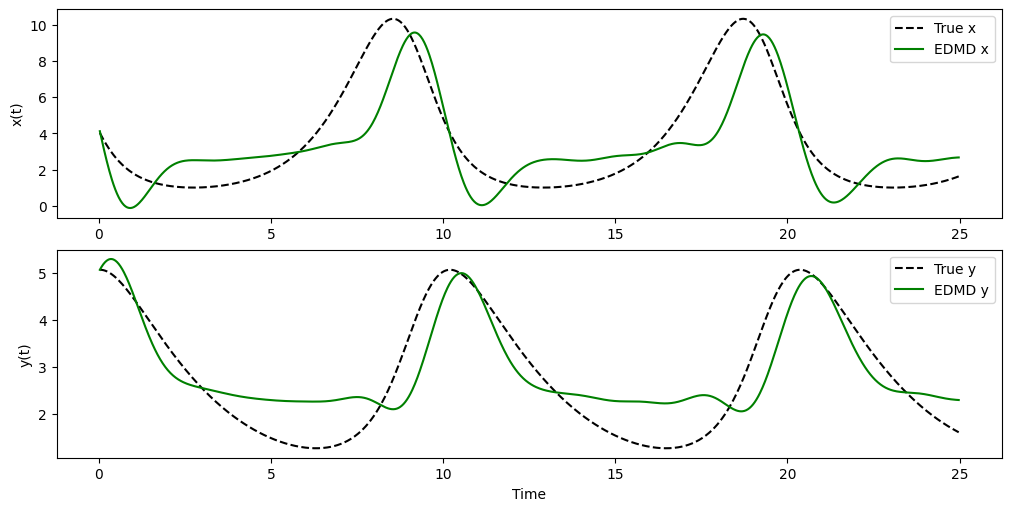

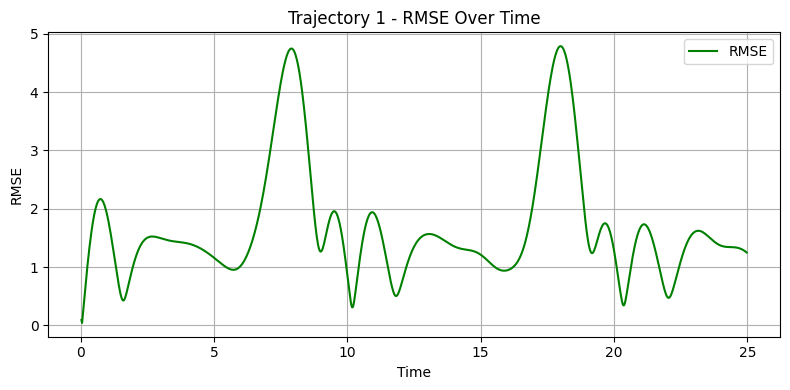


=== Lotka-Volterra Trajectory 2/10 ===


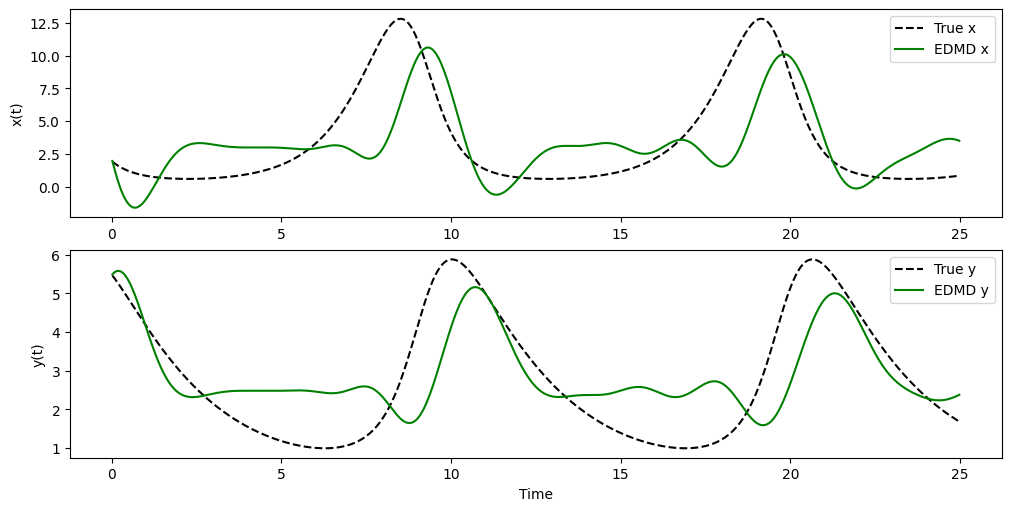

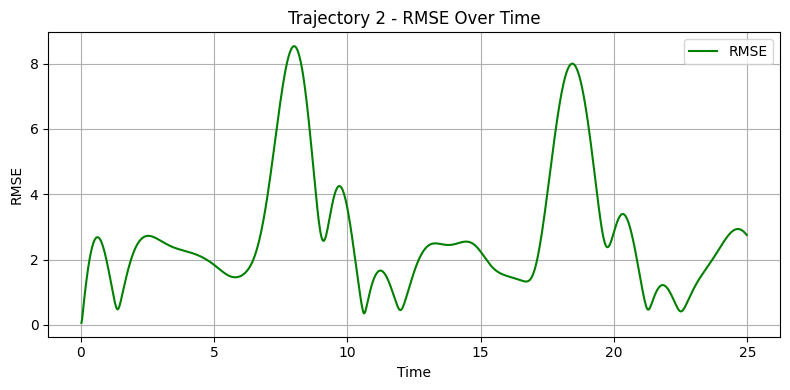


=== Lotka-Volterra Trajectory 3/10 ===


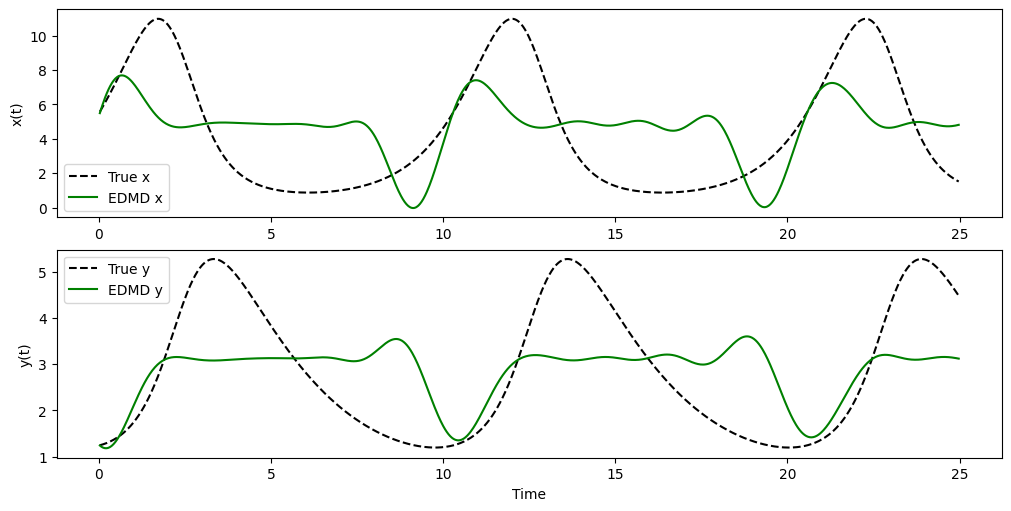

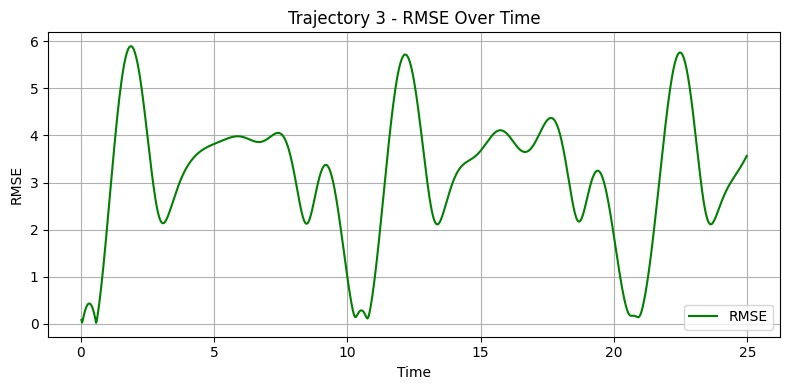


=== Lotka-Volterra Trajectory 4/10 ===


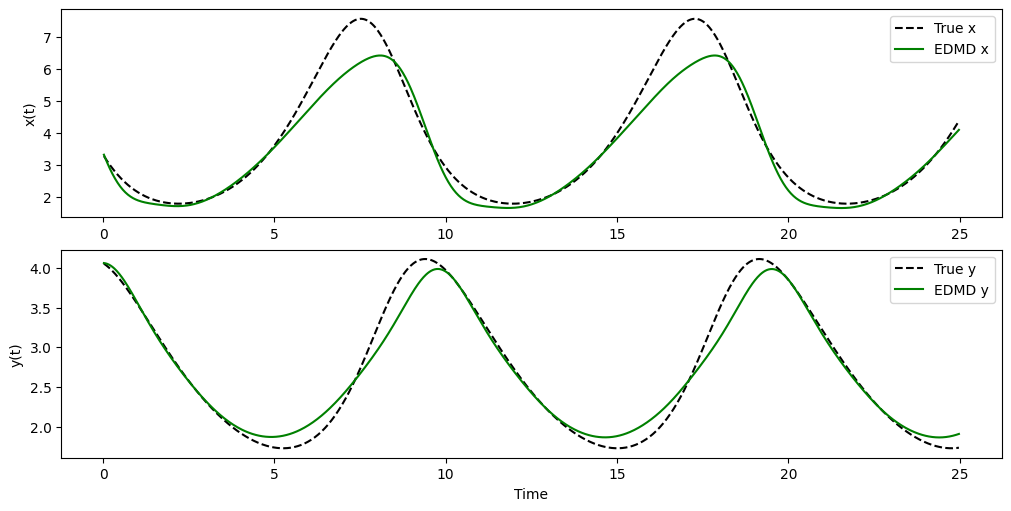

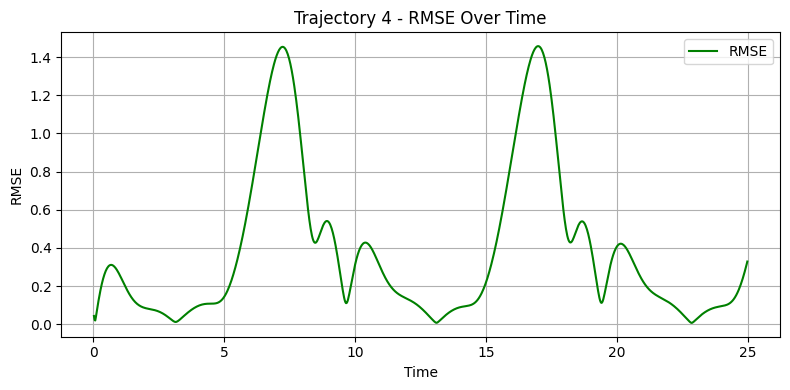


=== Lotka-Volterra Trajectory 5/10 ===


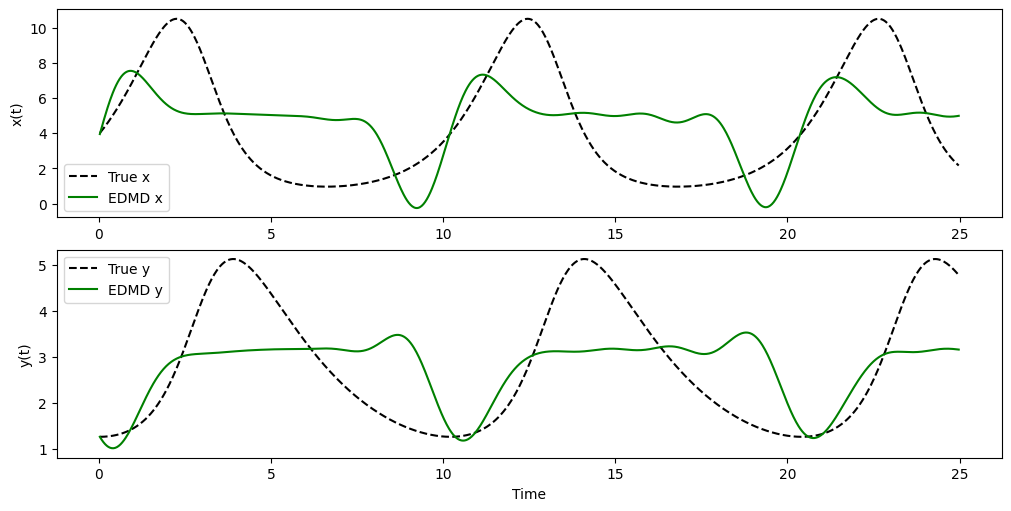

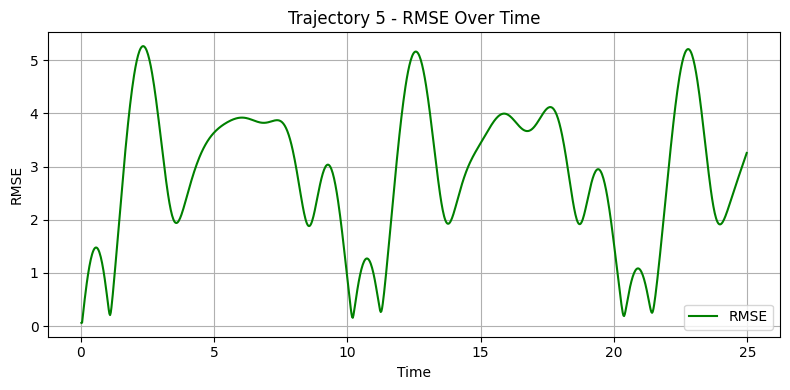


=== Lotka-Volterra Trajectory 6/10 ===


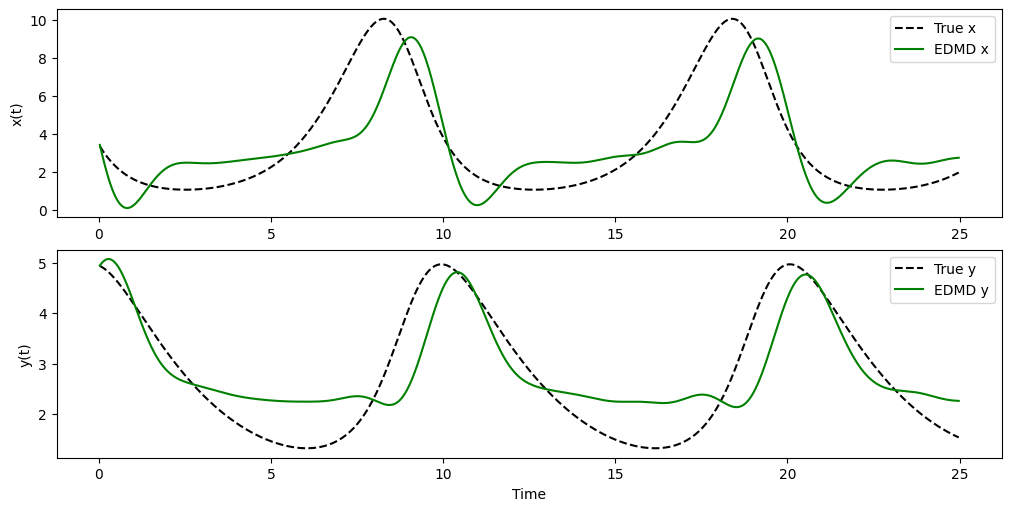

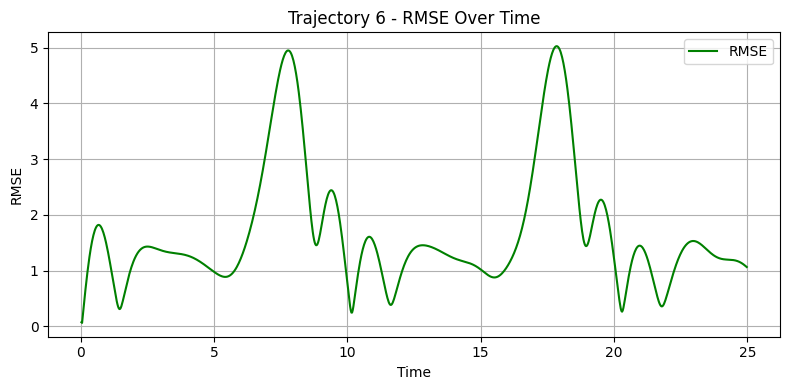


=== Lotka-Volterra Trajectory 7/10 ===


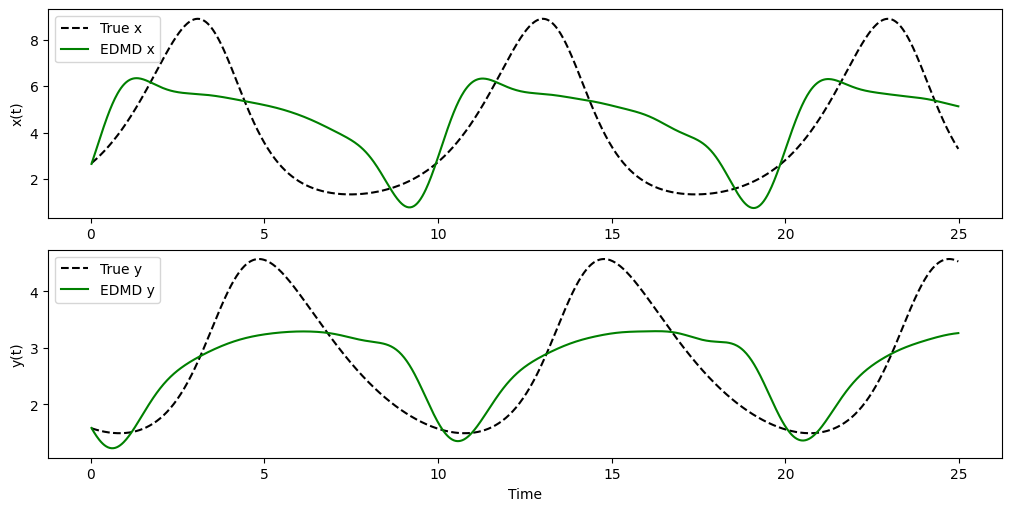

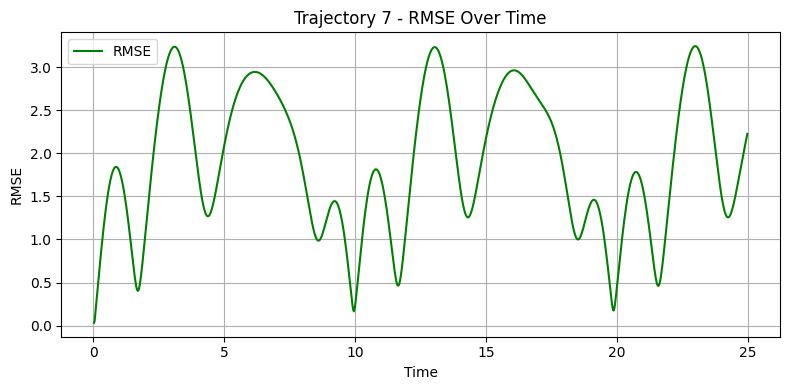


=== Lotka-Volterra Trajectory 8/10 ===


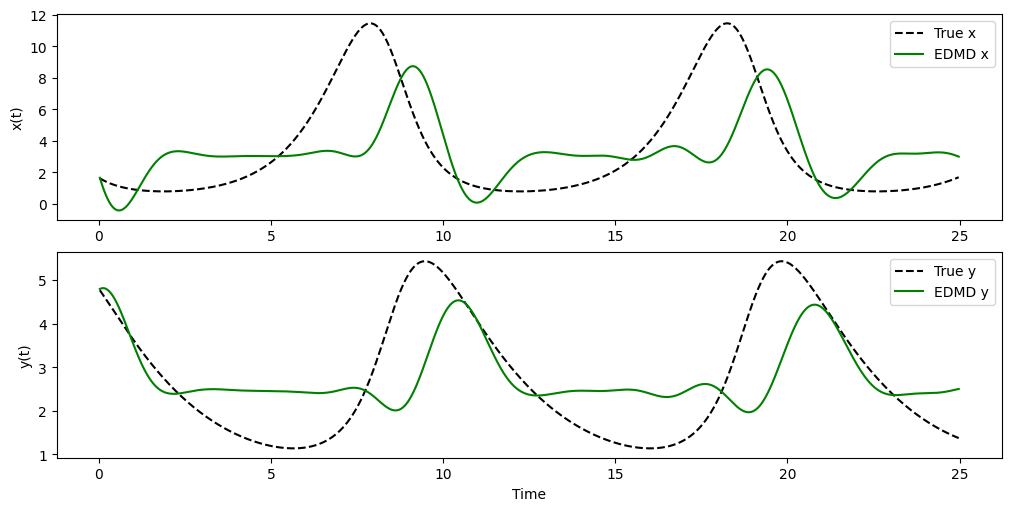

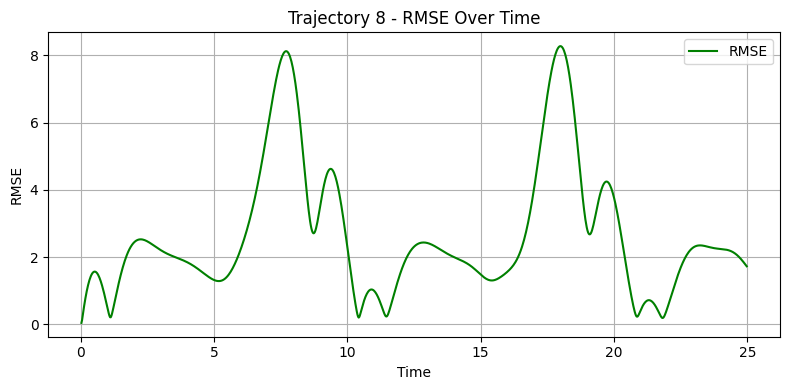


=== Lotka-Volterra Trajectory 9/10 ===


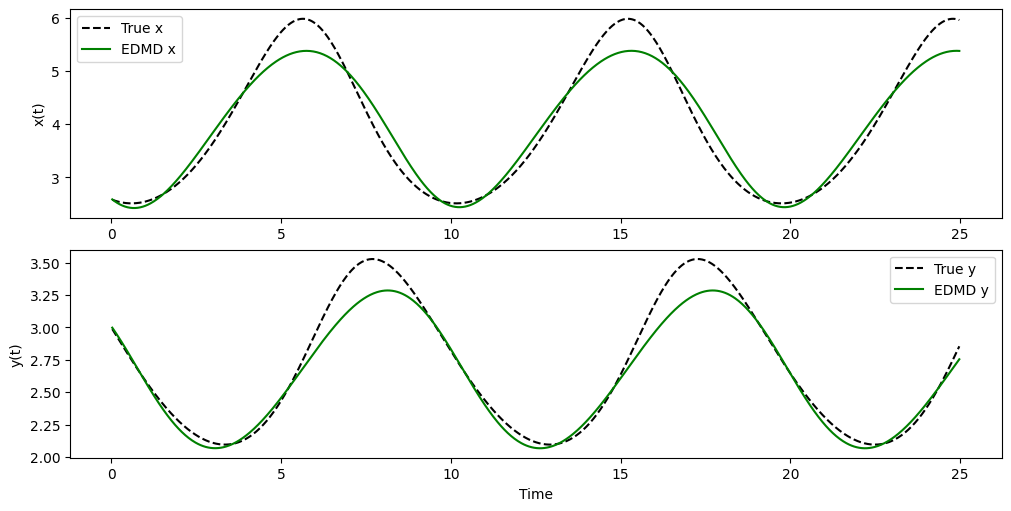

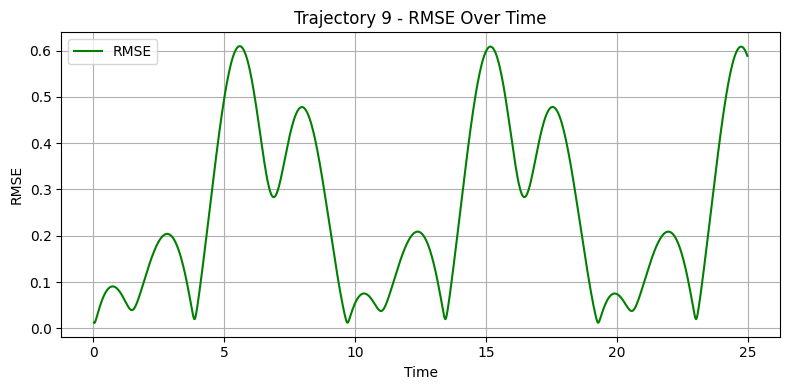


=== Lotka-Volterra Trajectory 10/10 ===


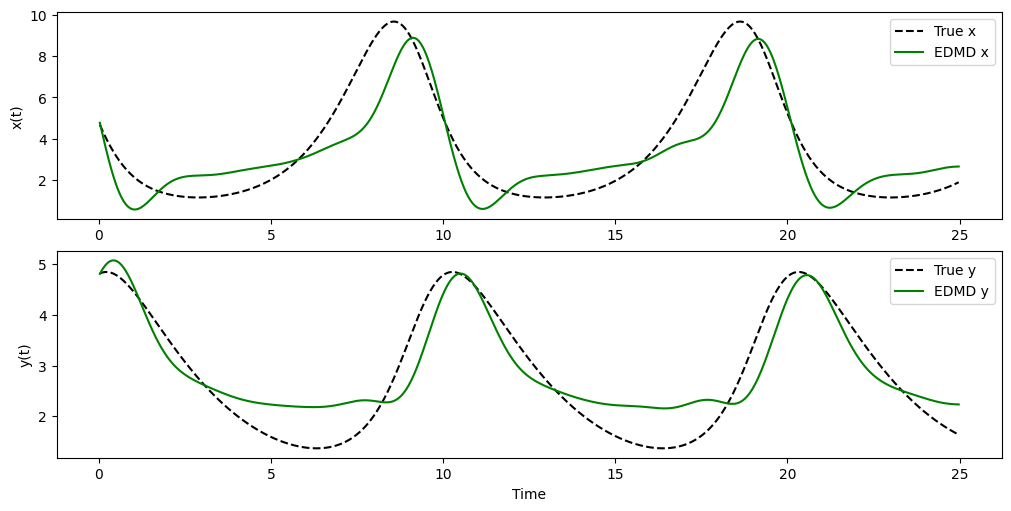

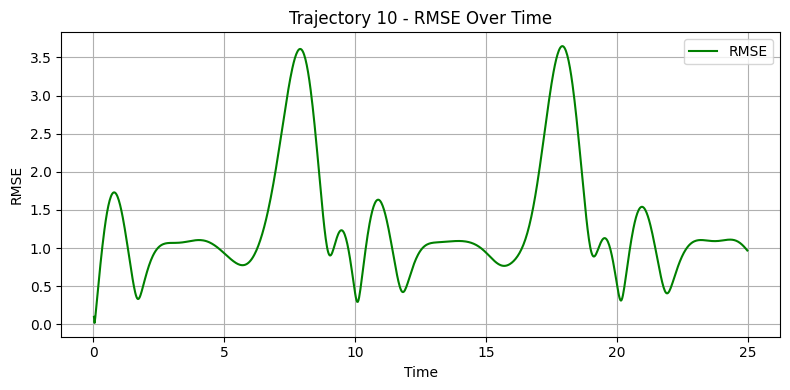

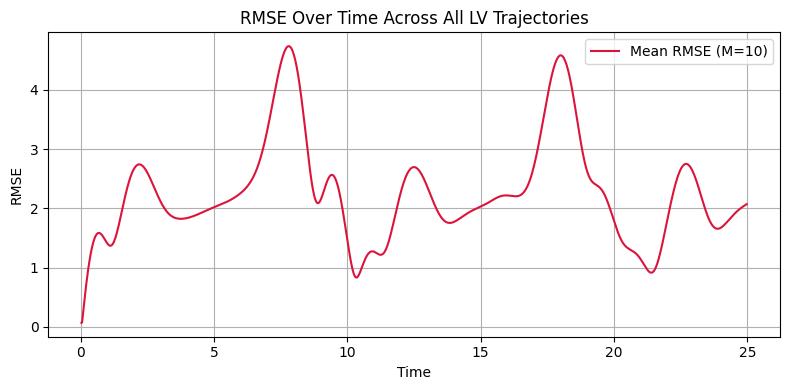

In [9]:
all_data = np.load("data/lotka_volterra.npz", allow_pickle=True)["trajectories"]
M = len(all_data)
KERNEL = 'rbf'
POLY_DEGREE = 10
SVD_RANK = 20

true_trajectories = []
pred_trajectories = []

for i in range(M):
    print(f"\n=== Lotka-Volterra Trajectory {i+1}/{M} ===")
    traj_data = all_data[i]
    z_data_np = traj_data["traj"]
    t_eval_np = traj_data["t"]

    scaler = StandardScaler()
    z_data_scaled = scaler.fit_transform(z_data_np)

    # Kernel EDMD
    X = z_data_scaled[:-1].T
    Y = z_data_scaled[1:].T

    if KERNEL == 'poly':
        dmd = EDMD(kernel_metric='polynomial', svd_rank=SVD_RANK, kernel_params={'degree': POLY_DEGREE})
    else:
        dmd = EDMD(kernel_metric=KERNEL, svd_rank=SVD_RANK)
    dmd.fit(X, Y)
    dmd.dmd_time['t0'] = 0
    dmd.dmd_time['tend'] = X.shape[1] - 1  # ensure alignment with reconstruction
    dmd.dmd_time['dt'] = 1

    reconstructed_scaled = dmd.reconstructed_data.T.real  # take real part
    reconstructed = scaler.inverse_transform(reconstructed_scaled)

    # Store trajectories
    true_trajectories.append(z_data_np[1:])  # align with predicted start at t1
    pred_trajectories.append(reconstructed)

    # Plot
    fig, axs = plt.subplots(2, 1, figsize=(10, 5), constrained_layout=True)
    t_plot = t_eval_np[1:]  # matches shape (len-1,)
    axs[0].plot(t_plot, z_data_np[1:, 0], 'k--', label='True x')
    axs[0].plot(t_plot, reconstructed[:, 0], 'g', label='EDMD x')
    axs[0].set_ylabel("x(t)")
    axs[0].legend()

    axs[1].plot(t_plot, z_data_np[1:, 1], 'k--', label='True y')
    axs[1].plot(t_plot, reconstructed[:, 1], 'g', label='EDMD y')
    axs[1].set_xlabel("Time")
    axs[1].set_ylabel("y(t)")
    axs[1].legend()
    plt.show()

    # Per-trajectory RMSE
    rmse_i = np.sqrt(np.sum((reconstructed - z_data_np[1:]) ** 2, axis=1))
    plt.figure(figsize=(8, 4))
    plt.plot(t_plot, rmse_i, color='green', label='RMSE')
    plt.title(f"Trajectory {i+1} - RMSE Over Time")
    plt.xlabel("Time")
    plt.ylabel("RMSE")
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

# Aggregate RMSE
rmse_t = compute_rmse_over_time(true_trajectories, pred_trajectories)
plt.figure(figsize=(8, 4))
plt.plot(t_plot, rmse_t, label="Mean RMSE (M=10)", color='crimson')
plt.xlabel("Time")
plt.ylabel("RMSE")
plt.title("RMSE Over Time Across All LV Trajectories")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Save RMSE data and label it as being from EDMD
np.savez("data/lotka_volterra_edmd_rmse.npz", rmse=rmse_t, t=t_plot, label="EDMD")

In [ ]:
data = np.load("data/lorenz.npz", allow_pickle=True)["trajectories"]
M = len(data)
KERNEL = 'rbf'
POLY_DEGREE = 2
SVD_RANK = 10

true_trajectories = []
pred_trajectories = []

for i in range(M):
    print(f"\n=== Lorenz Trajectory {i+1}/{M} ===")
    traj_data = data[i]
    z_data_np = traj_data["traj"]
    t_eval_np = traj_data["t"]

    scaler = StandardScaler()
    z_scaled = scaler.fit_transform(z_data_np)

    X = z_scaled[:-1].T
    Y = z_scaled[1:].T

    # Kernel EDMD with truncation to stabilize eigenmodes
    if KERNEL == 'poly':
        edmd = EDMD(kernel_metric='polynomial', svd_rank=SVD_RANK, kernel_params={'degree': POLY_DEGREE})
    else:
        edmd = EDMD(kernel_metric=KERNEL, svd_rank=SVD_RANK)
    edmd.fit(X, Y)
    edmd.dmd_time['t0'] = 0
    edmd.dmd_time['tend'] = X.shape[1] - 1  # match prediction shape
    edmd.dmd_time['dt'] = 1

    pred_scaled = edmd.reconstructed_data.T.real  # ensure real output
    pred = scaler.inverse_transform(pred_scaled)

    true_trajectories.append(z_data_np[1:])  # aligns with EDMD prediction
    pred_trajectories.append(pred)

    # Plot trajectory components
    fig, axs = plt.subplots(3, 1, figsize=(10, 8))
    t_plot = t_eval_np[1:]
    axs[0].plot(t_plot, z_data_np[1:, 0], 'k--', label='True x')
    axs[0].plot(t_plot, pred[:, 0], 'g', label='EDMD x')

    axs[1].plot(t_plot, z_data_np[1:, 1], 'k--', label='True y')
    axs[1].plot(t_plot, pred[:, 1], 'g', label='EDMD y')

    axs[2].plot(t_plot, z_data_np[1:, 2], 'k--', label='True z')
    axs[2].plot(t_plot, pred[:, 2], 'g', label='EDMD z')

    for ax in axs:
        ax.legend()
    axs[2].set_xlabel("Time")
    plt.suptitle(f"Lorenz Trajectory {i+1}")
    plt.tight_layout()
    plt.show()

    # RMSE per trajectory
    rmse = np.sqrt(np.sum((pred - z_data_np[1:]) ** 2, axis=1))
    plt.plot(t_plot, rmse, color='green', label="RMSE")
    plt.title(f"RMSE Over Time – Trajectory {i+1}")
    plt.xlabel("Time")
    plt.ylabel("RMSE")
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

    # --- 3D Quiver Plot with Directional Arrows ---
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    min_arrow_spacing = 2.0
    pred_np = pred

    arrow_indices_true = sample_arrows_by_distance(z_data_np, min_arrow_spacing)
    arrow_indices_pred = sample_arrows_by_distance(pred_np, min_arrow_spacing)

    for j in arrow_indices_true[:-1]:
        p0 = z_data_np[j]
        p1 = z_data_np[j + 1]
        direction = p1 - p0
        ax.quiver(*p0, *direction, color='r', length=1.0, normalize=True, linewidth=2.5)

    for j in arrow_indices_pred[:-1]:
        p0 = pred_np[j]
        p1 = pred_np[j + 1]
        direction = p1 - p0
        ax.quiver(*p0, *direction, color='orange', length=1.0, normalize=True, linewidth=1.5)

    ax.plot(z_data_np[:, 0], z_data_np[:, 1], z_data_np[:, 2], 'k--', label='True trajectory')
    ax.plot(pred_np[:, 0], pred_np[:, 1], pred_np[:, 2], 'b', label='Neural ODE prediction')

    ax.set_xlabel("x(t)")
    ax.set_ylabel("y(t)")
    ax.set_zlabel("z(t)")
    ax.set_title(f"Trajectory {i+1}: Lorenz 3D Trajectories with Arrows")
    ax.legend()

    plt.tight_layout()
    plt.show()

# Aggregate RMSE over all trajectories
rmse_t = compute_rmse_over_time(true_trajectories, pred_trajectories)
plt.figure(figsize=(8, 4))
plt.plot(t_plot, rmse_t, label="Mean RMSE (M=10)", color='crimson')
plt.xlabel("Time")
plt.ylabel("RMSE")
plt.title("RMSE Over Time Across All Lorenz Trajectories")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Save RMSE data and label it as being from EDMD
np.savez("data/lorenz_edmd_rmse.npz", rmse=rmse_t, t=t_plot, label="EDMD")